In [33]:
import pandas as pd
import seaborn as sb

In [34]:
# Read the CSV file into a DataFrame
teams_stats = pd.read_csv('../basketballPlayoffs/teams_stats_rating_sys.csv')
teams_stats_encoded = pd.read_csv('../basketballPlayoffs/teams_stats_encoded.csv')
teams_data = pd.read_csv("../basketballPlayoffs/teams.csv")

print(teams_stats.head)
print(teams_data.head)


<bound method NDFrame.head of     tmID  year  points_prev1  oRebounds_prev1  dRebounds_prev1  \
0    ATL     9     81.611488        11.152772        23.502194   
1    ATL    10     84.359673        13.558583        26.855586   
2    CHA     2     78.641601         9.702850        20.861128   
3    CHA     3     74.541358        11.123270        22.092050   
4    CHA     4     82.401055        10.646438        22.321900   
..   ...   ...           ...              ...              ...   
121  WAS     6     72.566641        11.990861        23.250571   
122  WAS     7     79.400341         9.403748        22.037479   
123  WAS     8     95.939850        11.094403        26.566416   
124  WAS     9     88.765103        12.926480        25.852959   
125  WAS    10     86.334842        12.995475        25.085973   

     rebounds_prev1  assists_prev1  steals_prev1  blocks_prev1  \
0         34.654966      17.423215      8.232948      3.063422   
1         40.414169      15.912807      9.634

In [35]:
from sklearn.ensemble import RandomForestRegressor

def get_rating_rf(year):
    from sklearn.model_selection import train_test_split

    training_data = teams_stats_encoded[(teams_stats_encoded['year'] >= 2) & (teams_stats_encoded['year'] <= year - 1)]
    test_data = teams_stats_encoded[teams_stats_encoded['year'] == year]

    X_train = training_data.drop(['tmID', 'year', 'confID', 'playoff'], axis=1)
    y_train = training_data['playoff']
    X_test = test_data.drop(['tmID', 'year', 'confID', 'playoff'], axis=1)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)

    rfRatingMult = {}
    for feature, importance in feature_importance.items():
        rfRatingMult[feature] = importance

    # Calculate the 'rating' column based on multipliers
    teams_stats['rating'] = sum(teams_stats[column] * rfRatingMult[column] for column in rfRatingMult)

In [36]:
def get_rating_lr(year):
    from sklearn.linear_model import LinearRegression

    training_data=teams_stats_encoded[(teams_stats_encoded['year'] >= 2) & (teams_stats_encoded['year'] <= year-1)]

    X = training_data.drop(['tmID', 'year', 'confID', 'playoff'], axis=1)
    y = training_data['playoff']

    model = LinearRegression()
    model.fit(X, y)

    feature_importance = pd.Series(model.coef_, index=X.columns)

    lrRatingMult = {}
    for feature, importance in zip(X.columns, feature_importance):
        lrRatingMult[feature] = importance

    # Calculate the 'rating' column based on multipliers
    teams_stats['rating'] = sum(teams_stats[column] * lrRatingMult[column] for column in lrRatingMult)

In [37]:
import lightgbm as lgb
from matplotlib import pyplot as plt

def get_rating_lgbm(year):
    from sklearn.model_selection import train_test_split

    training_data = teams_stats_encoded[(teams_stats_encoded['year'] >= 2) & (teams_stats_encoded['year'] <= year - 1)]
    test_data = teams_stats_encoded[teams_stats_encoded['year'] == year]

    X_train = training_data.drop(['tmID', 'year', 'confID', 'playoff'], axis=1)
    y_train = training_data['playoff']
    X_test = test_data.drop(['tmID', 'year', 'confID', 'playoff'], axis=1)

    params = {
        'bagging_fraction': 0.8, 'bagging_freq': 7, 'boosting_type': 'gbdt',
        'class_weight': None, 'colsample_bytree': 1.0, 'feature_fraction': 1.0,
        'importance_type': 'split', 'learning_rate': 0.005, 'max_depth': -1,
        'min_child_samples': 16, 'min_child_weight': 0.001, 'min_split_gain': 0.9,
        'n_estimators': 240, 'n_jobs': -1, 'num_leaves': 90, 'objective': None,
        'random_state': 420, 'reg_alpha': 0.15, 'reg_lambda': 0.7, 'subsample': 1.0,
        'subsample_for_bin': 200000, 'subsample_freq': 0
    }

    lgb_train = lgb.Dataset(X_train, y_train)

    model = lgb.train(params, lgb_train, num_boost_round=100)

    feature_importance = model.feature_importance(importance_type='gain')

    lgbRatingMult = {}
    for i, column in enumerate(X_train.columns):
        lgbRatingMult[column] = feature_importance[i]

    # Calculate the 'rating' column based on multipliers
    teams_stats['rating'] = sum(teams_stats[column] * lgbRatingMult[column] for column in lgbRatingMult)

    # Convert feature_importance dictionary to a Pandas Series
    feature_importance_series = pd.Series(lgbRatingMult)

    plt.figure(figsize=(10, 6))
    sb.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")
    plt.xlabel('Importance')
    plt.title('Feature Importance in LightGBM')
    plt.show()

In [38]:
import xgboost as xgb

def get_rating_xgb(year):
    from sklearn.model_selection import train_test_split

    training_data = teams_stats_encoded[(teams_stats_encoded['year'] >= 2) & (teams_stats_encoded['year'] <= year - 1)]
    test_data = teams_stats_encoded[teams_stats_encoded['year'] == year]

    X_train = training_data.drop(['tmID', 'year', 'confID', 'playoff'], axis=1)
    y_train = training_data['playoff']
    X_test = test_data.drop(['tmID', 'year', 'confID', 'playoff'], axis=1)

    params = {
        'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.5, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'n_estimators': 300
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    model = xgb.train(params, dtrain, num_boost_round=100)

    importance = model.get_score(importance_type='gain')

    xgbRatingMult = {}
    for column, gain in importance.items():
        xgbRatingMult[column] = gain

    # Calculate the 'rating' column based on multipliers
    teams_stats['rating'] = sum(teams_stats[column] * xgbRatingMult[column] for column in xgbRatingMult)

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

def get_rating_gb(year):
    from sklearn.model_selection import train_test_split

    training_data = teams_stats_encoded[(teams_stats_encoded['year'] >= 2) & (teams_stats_encoded['year'] <= year - 1)]
    test_data = teams_stats_encoded[teams_stats_encoded['year'] == year]

    X_train = training_data.drop(['tmID', 'year', 'confID', 'playoff'], axis=1)
    y_train = training_data['playoff']
    X_test = test_data.drop(['tmID', 'year', 'confID', 'playoff'], axis=1)

    params = {
        'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss',
        'max_depth': 11, 'max_features': 'sqrt', 'min_impurity_decrease': 0.002, 'min_samples_leaf': 1,
        'min_samples_split': 7, 'n_estimators': 190, 'random_state': 69, 'subsample': 0.9, 'tol': 0.0001,
        'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False
    }

    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)

    feature_importance = model.feature_importances_

    gbRatingMult = {}
    for i, column in enumerate(X_train.columns):
        gbRatingMult[column] = feature_importance[i]

    # Calculate the 'rating' column based on multipliers
    teams_stats['rating'] = sum(teams_stats[column] * gbRatingMult[column] for column in gbRatingMult)


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\h_enr\AppData\Local\Temp\ipykernel_12924\3198275729.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")


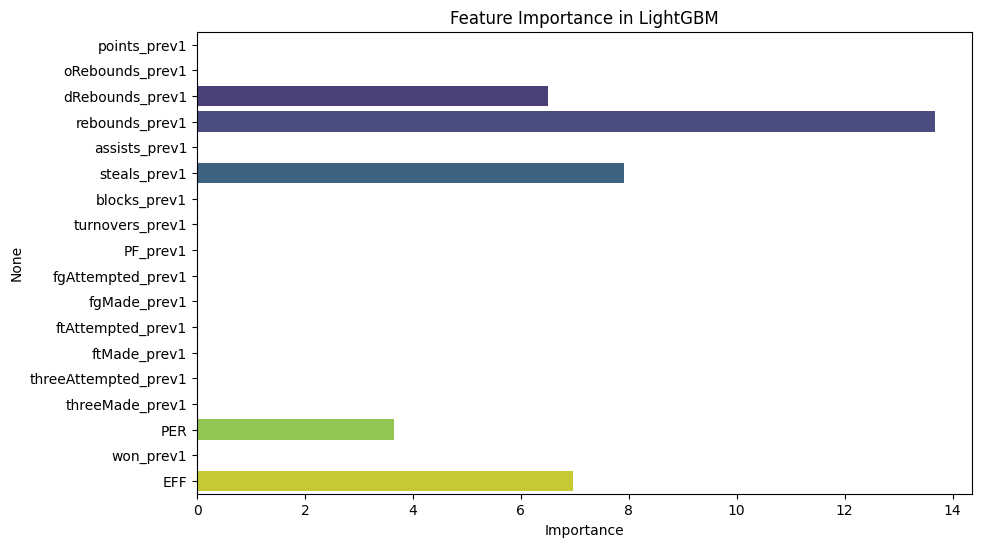

East Conference Teams:
   tmID  year  points_prev1  oRebounds_prev1  dRebounds_prev1  rebounds_prev1  \
43  IND     6     80.217391        13.980978        24.986413       38.967391   
17  CON     6     80.607846        10.569080        25.752830       36.321910   
26  DET     6     77.546076        12.434592        25.920866       38.355458   
72  NYL     6     76.325493         7.476160        24.717101       32.193261   

    assists_prev1  steals_prev1  blocks_prev1  turnovers_prev1  ...  \
43      18.423913      9.904891      4.524457        16.467391  ...   
17      20.282214     10.122500      5.135680        16.597922  ...   
26      20.971775      9.341410      4.701637        17.569274  ...   
72      19.720280      7.552448      4.233948        17.050223  ...   

    ftAttempted_prev1  ftMade_prev1  threeAttempted_prev1  threeMade_prev1  \
43          21.236413     16.508152             16.589674         5.828804   
17          20.207784     14.662738             15.258180  

C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\h_enr\AppData\Local\Temp\ipykernel_12924\3198275729.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")


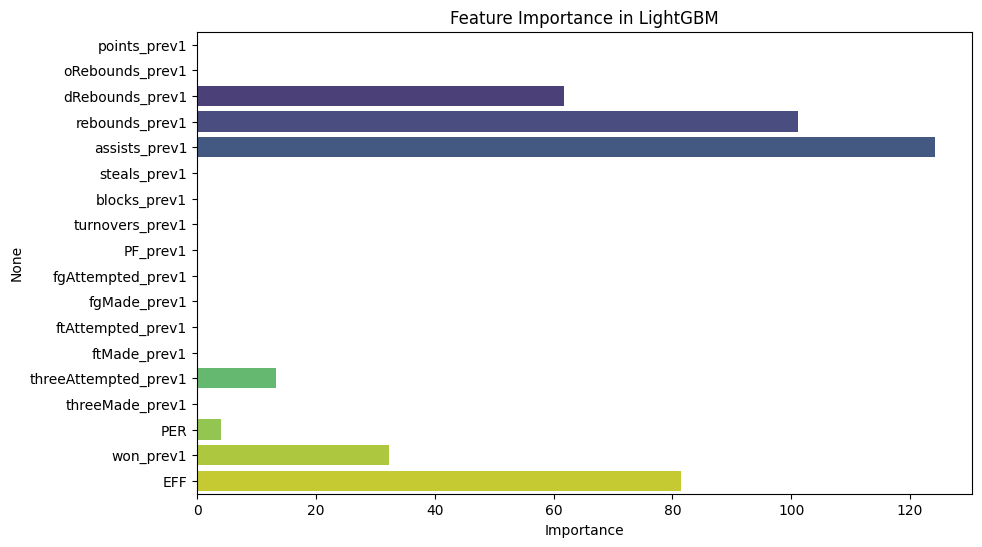

East Conference Teams:
    tmID  year  points_prev1  oRebounds_prev1  dRebounds_prev1  \
18   CON     7     93.132550        11.398312        27.721330   
27   DET     7     83.707777        14.988217        29.316575   
44   IND     7     75.451145         9.768068        22.373186   
122  WAS     7     79.400341         9.403748        22.037479   

     rebounds_prev1  assists_prev1  steals_prev1  blocks_prev1  \
18        39.119643      19.778256      8.419659      4.726129   
27        44.304792      14.234093      7.729772      6.692852   
44        32.141254      17.596888     10.809517      2.406105   
122       31.441227      14.759796      8.790460      2.616695   

     turnovers_prev1  ...  ftAttempted_prev1  ftMade_prev1  \
18         15.409565  ...          25.894423     19.539964   
27         19.277298  ...          28.232522     18.947368   
44         15.837199  ...          22.157714     17.309592   
122        13.696763  ...          19.747871     14.146508   

    

C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\h_enr\AppData\Local\Temp\ipykernel_12924\3198275729.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")


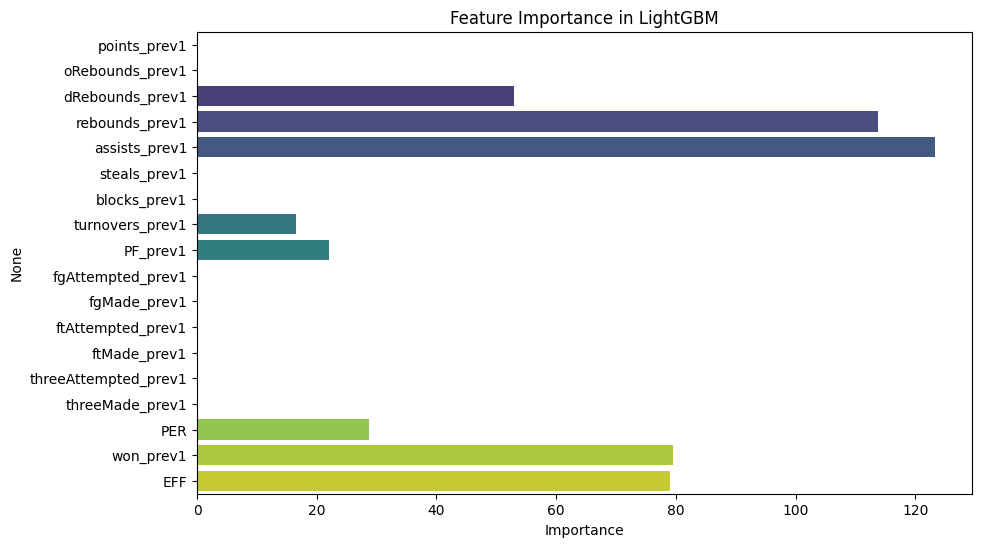

East Conference Teams:
    tmID  year  points_prev1  oRebounds_prev1  dRebounds_prev1  \
19   CON     8     86.964135        11.234215        31.560869   
28   DET     8     90.260790        13.872198        29.171877   
123  WAS     8     95.939850        11.094403        26.566416   
45   IND     8     88.871834        12.524942        26.738296   

     rebounds_prev1  assists_prev1  steals_prev1  blocks_prev1  \
19        42.795083      21.134871      8.607510      5.859572   
28        43.044075      21.741650      8.857709      3.440598   
123       37.660819      19.715957     10.359231      4.310777   
45        39.263239      17.436685     12.371450      4.451266   

     turnovers_prev1  ...  ftAttempted_prev1  ftMade_prev1  \
19         15.396531  ...          20.447887     16.730089   
28         18.008235  ...          29.794113     22.290682   
123        17.744361  ...          25.162907     18.613200   
45         17.375288  ...          26.830391     19.953952   

    

C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\h_enr\AppData\Local\Temp\ipykernel_12924\3198275729.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")


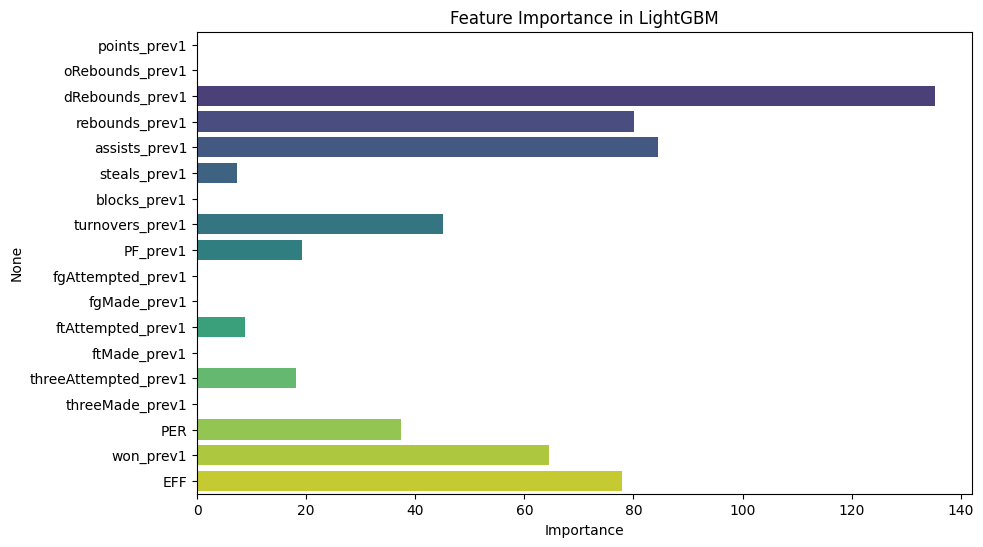

East Conference Teams:
   tmID  year  points_prev1  oRebounds_prev1  dRebounds_prev1  rebounds_prev1  \
29  DET     9     88.899938        12.193909        30.540709       42.734618   
46  IND     9     92.894118        11.415126        27.428571       38.843697   
20  CON     9     93.093373        10.467923        26.982850       37.450773   
10  CHI     9     84.708270        13.231862        28.046677       41.278539   

    assists_prev1  steals_prev1  blocks_prev1  turnovers_prev1  ...  \
29      18.011187      8.427595      4.139217        16.967060  ...   
46      21.055462     12.988235      5.122689        21.095798  ...   
20      21.850519      8.841838      2.286682        18.039382  ...   
10      20.740741      9.497717      4.342973        15.910705  ...   

    ftAttempted_prev1  ftMade_prev1  threeAttempted_prev1  threeMade_prev1  \
29          24.760721     18.831572             14.766936         5.034183   
46          25.290756     19.885714             21.458824  

C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\h_enr\AppData\Local\Temp\ipykernel_12924\3198275729.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=feature_importance_series.values, y=feature_importance_series.index, palette="viridis")


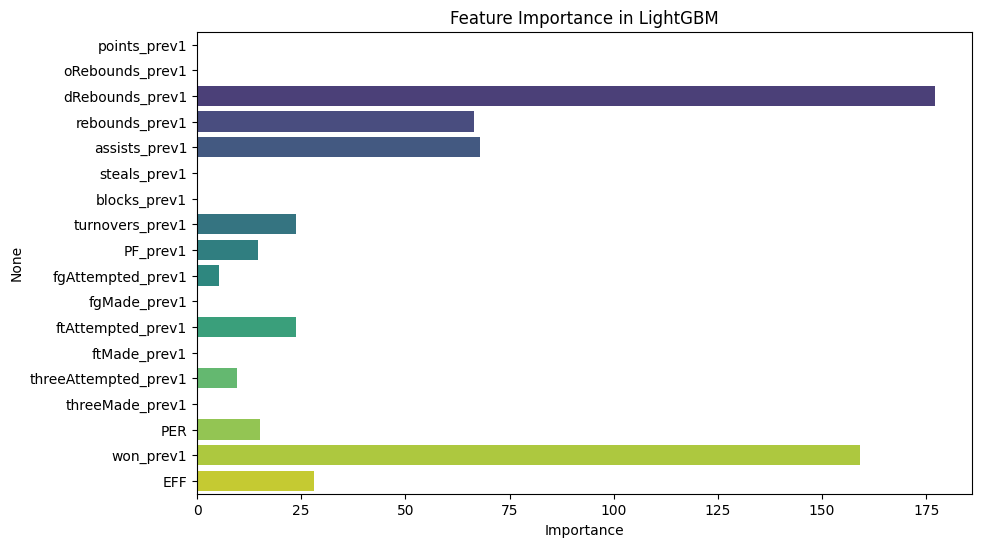

East Conference Teams:
   tmID  year  points_prev1  oRebounds_prev1  dRebounds_prev1  rebounds_prev1  \
30  DET    10     88.879603        12.723949        28.613215       41.337164   
21  CON    10     96.914352        11.586448        28.442635       40.029082   
76  NYL    10     89.731259        12.560113        26.930693       39.490806   
47  IND    10     82.270598        13.855056        28.404519       42.259576   

    assists_prev1  steals_prev1  blocks_prev1  turnovers_prev1  ...  \
30      20.621572      9.934709      3.729433        15.920606  ...   
21      21.951432      7.887160      3.734186        16.995783  ...   
76      19.311645      9.957567      3.922678        17.652051  ...   
47      16.599614     11.308901      5.290714        18.087627  ...   

    ftAttempted_prev1  ftMade_prev1  threeAttempted_prev1  threeMade_prev1  \
30          25.479237     18.897885             16.954818         6.048577   
21          25.441326     19.508507             23.033299  

In [40]:

def teams_passing_year(year):
    # Filter the results DataFrame by year and conference
    year_conf_results = teams_stats[(teams_stats['year'] == year) & (teams_stats['confID'] == 'EA')]

    # Sort the East conference results by 'rating' in descending order and select the top 4 teams
    east_teams = year_conf_results.sort_values(by='rating', ascending=False).head(4)

    # Filter the results DataFrame by year and conference
    year_conf_results = teams_stats[(teams_stats['year'] == year) & (teams_stats['confID'] == 'WE')]

    # Sort the West conference results by 'rating' in descending order and select the top 4 teams
    west_teams = year_conf_results.sort_values(by='rating', ascending=False).head(4)

    print("East Conference Teams:")
    print(east_teams)

    print("West Conference Teams:")
    print(west_teams)
    return (east_teams, west_teams)

def test_rating():
    correct = 0
    times = 0
    for i in range(6, 11):
        get_rating_lgbm(i)
        eastTeams, westTeams = teams_passing_year(i)
        for team in teams_data['tmID'].unique():
            if not (teams_data[(teams_data['tmID'] == team) & (teams_data['year'] == i)].empty):
                if (teams_data[(teams_data['tmID'] == team) & (teams_data['year'] == i)]['playoff'].iloc[0] == 'Y'):
                    if (eastTeams['tmID'].str.contains(team).any() or westTeams['tmID'].str.contains(team).any()):
                        correct += 1
                    times += 1
                if (teams_data[(teams_data['tmID'] == team) & (teams_data['year'] == i)]['playoff'].iloc[0] == 'N'):
                    if not (eastTeams['tmID'].str.contains(team).any() or westTeams['tmID'].str.contains(team).any()):
                        correct += 1
                    times += 1
    acc = correct/times
    print(acc)
        
test_rating()


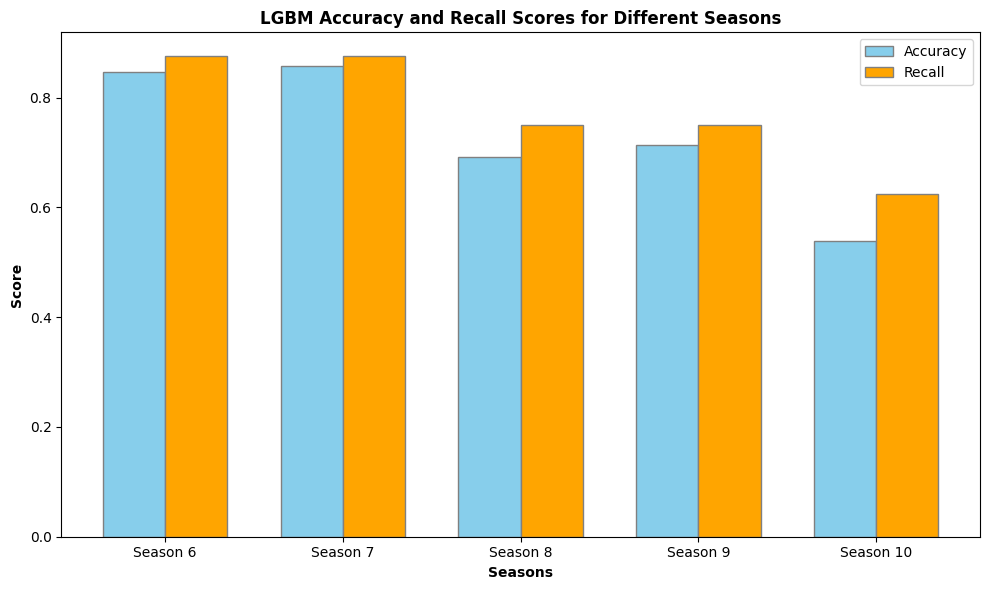

In [44]:
import matplotlib.pyplot as plt

# Accuracy and Recall values
accuracy = [0.8462, 0.8571, 0.6923, 0.7143, 0.5385]
recall = [0.875, 0.875, 0.75, 0.75, 0.625]

# Create a list of labels for each bar
labels = ['Season 6', 'Season 7', 'Season 8', 'Season 9', 'Season 10']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(accuracy))
r2 = [x + bar_width for x in r1]

# Create bar plot for accuracy
plt.figure(figsize=(10, 6))
plt.bar(r1, accuracy, color='skyblue', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, recall, color='orange', width=bar_width, edgecolor='grey', label='Recall')

# Add labels, title, and legend
plt.xlabel('Seasons', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(accuracy))], labels)
plt.ylabel('Score', fontweight='bold')
plt.title('LGBM Accuracy and Recall Scores for Different Seasons', fontweight='bold')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
